In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS07.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (7219962, 4)
X_s shape: (7219962, 14)
X_v shape: (7219962, 14)
T shape: (7219962, 10)
A shape: (7219962, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


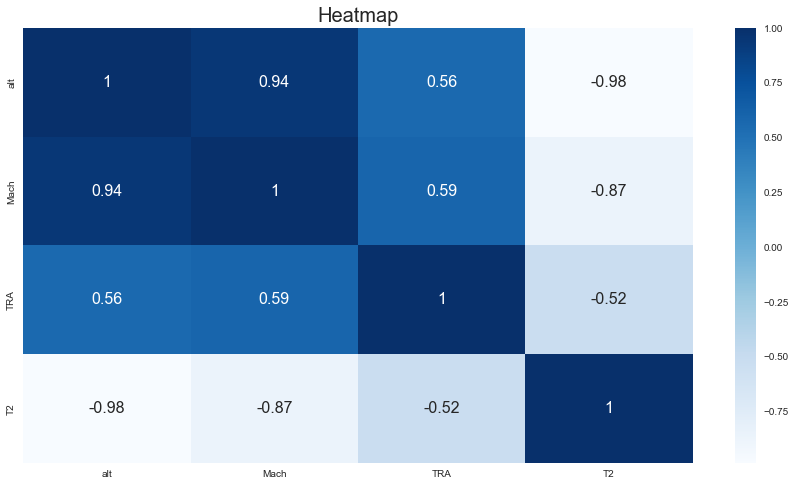

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,628.042667,1511.321539,1926.531777,1305.716844,20.030600,14.445617,20.335634,25.652134,433.667246,440.413903,16.508168,2240.817076,8822.151341,5.280492,1.0,3002.0,0.370377,81.122467,521.900827,1.0
1,628.030676,1511.266957,1926.545472,1305.729983,20.027941,14.444604,20.332935,25.648438,433.581419,440.325438,16.504423,2240.682993,8821.934705,5.279754,1.0,3010.0,0.370818,81.122467,521.904702,1.0
2,628.037901,1511.256216,1926.497756,1305.662340,20.027044,14.444141,20.332025,25.647647,433.541962,440.285902,16.501093,2240.711260,8821.904115,5.279080,1.0,3017.0,0.371259,81.122467,521.912580,1.0
3,628.049963,1511.249074,1926.457422,1305.580575,20.025528,14.443352,20.330486,25.646253,433.485825,440.229389,16.495964,2240.760174,8821.882308,5.278224,1.0,3030.0,0.372078,81.122467,521.926210,1.0
4,628.053010,1511.208545,1926.360048,1305.474914,20.023754,14.442366,20.328685,25.644478,433.409814,440.153048,16.491161,2240.761581,8821.756077,5.276998,1.0,3038.0,0.372519,81.122467,521.930527,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219957,566.459593,1258.643737,1497.397109,1137.314974,16.047061,13.748366,16.291432,18.353409,223.357349,227.987269,14.232466,1591.927196,7975.777436,2.140171,10.0,3018.0,0.258741,26.367001,514.708718,87.0
7219958,566.497803,1258.704446,1497.462049,1137.351624,16.051913,13.752884,16.296358,18.359057,223.412506,228.043709,14.235118,1591.978677,7975.971226,2.140743,10.0,3013.0,0.259182,26.367001,514.748340,87.0
7219959,566.470161,1258.685975,1497.360571,1137.300341,16.049388,13.749745,16.293795,18.356251,223.405834,228.037402,14.236747,1591.998128,7975.952634,2.140410,10.0,3009.0,0.258111,26.367001,514.707340,87.0
7219960,566.514360,1258.753800,1497.570601,1137.449455,16.055003,13.755381,16.299496,18.362443,223.464416,228.096246,14.238965,1591.981083,7976.122915,2.141432,10.0,3006.0,0.258930,26.367001,514.762020,87.0


In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

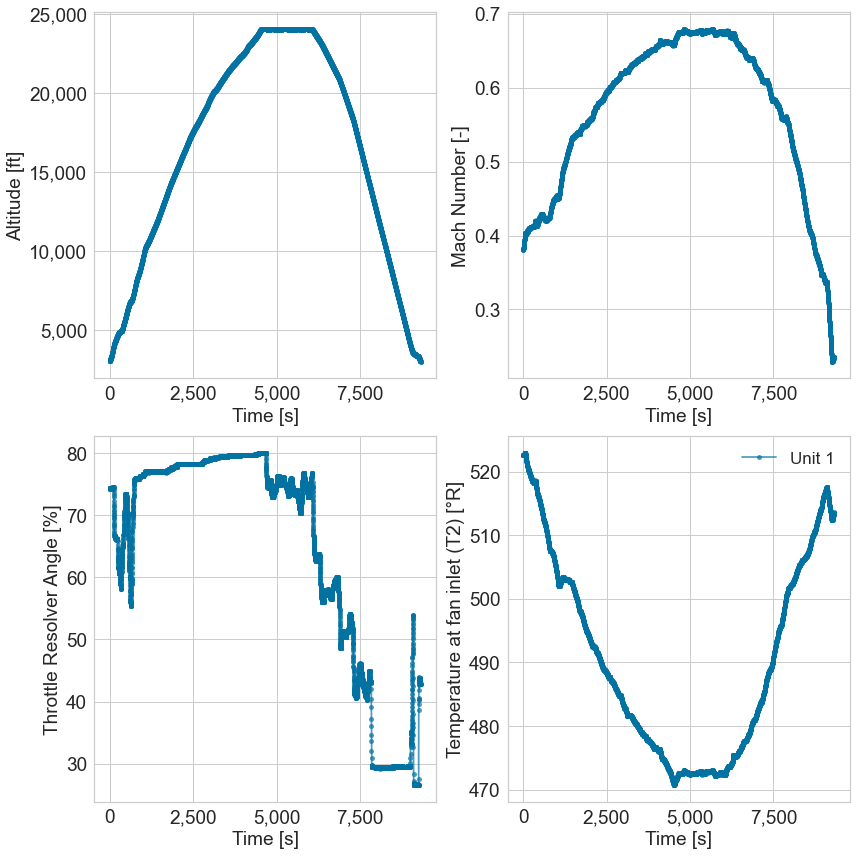

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[   3013    3014    3017 ... 7217762 7217764 7217766]


<Figure size 432x288 with 0 Axes>

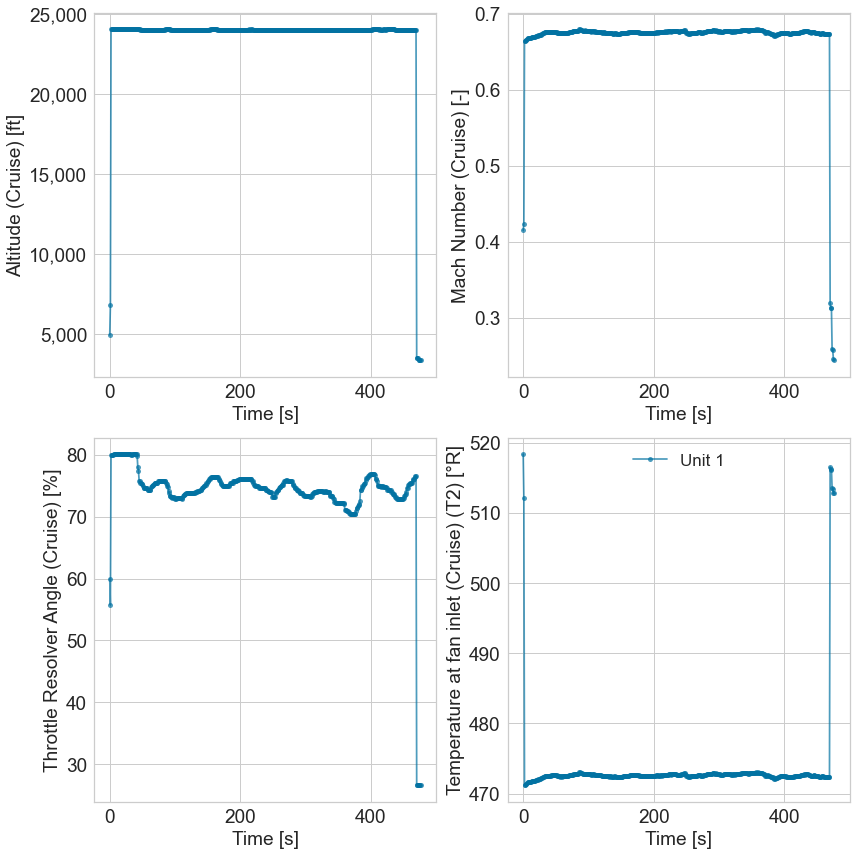

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

-2.7108627730239586e-15 1.0000000000000002
(892236, 19)


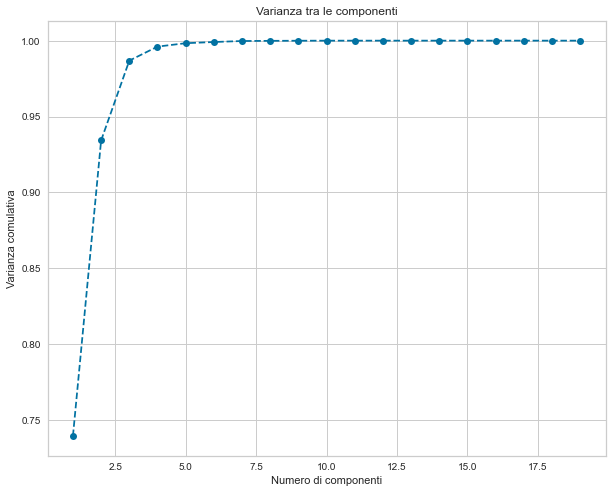

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

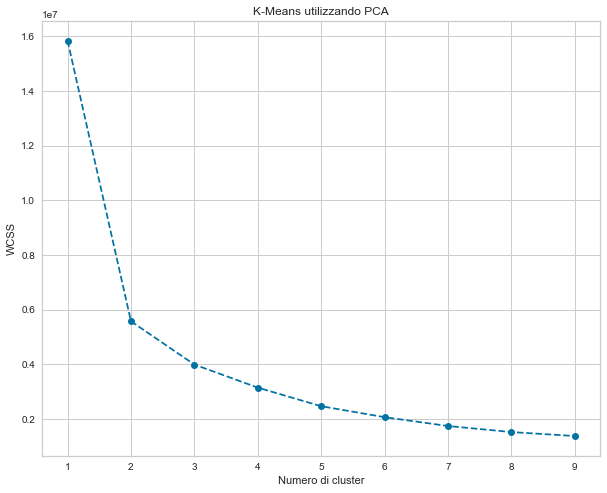

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

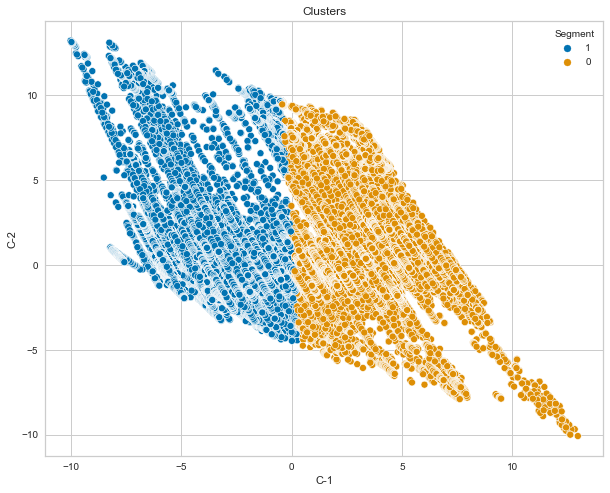

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,3013,567.860041,1359.283102,1706.566019,1126.359986,10.799866,7.907752,10.964331,13.876825,223.949725,...,1.0,22984.0,0.652869,79.452560,473.933456,1.0,-0.964095,-2.897319,1,1
1,3014,567.585882,1357.937968,1703.216912,1124.405608,10.788754,7.907769,10.953050,13.855286,223.166222,...,1.0,22984.0,0.652869,79.100998,473.933744,1.0,-1.014151,-2.796335,1,1
2,3017,566.637824,1353.714643,1695.546160,1120.678822,10.752866,7.912485,10.916615,13.781670,220.809029,...,1.0,22985.0,0.653625,77.958427,474.016431,1.0,-1.145399,-2.508565,1,1
3,3020,566.013942,1351.183604,1690.745730,1118.349690,10.728988,7.913807,10.892374,13.733419,219.395264,...,1.0,22987.0,0.653940,77.255310,474.042937,1.0,-1.226378,-2.332506,1,1
4,3021,565.756395,1350.421189,1690.046640,1118.230185,10.717152,7.910579,10.880357,13.713054,218.979795,...,1.0,22987.0,0.653436,77.079529,473.987688,1.0,-1.247934,-2.288744,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892231,7217758,578.124715,1349.021582,1694.764244,1161.650520,13.418996,10.390338,13.623346,16.690717,248.965434,...,10.0,14740.0,0.565425,61.786671,495.908312,87.0,2.060266,-1.222993,0,0
892232,7217759,578.136214,1349.041398,1694.838493,1161.705691,13.419978,10.391273,13.624343,16.691884,248.979196,...,10.0,14740.0,0.565551,61.786671,495.921066,87.0,2.061792,-1.224536,0,0
892233,7217762,578.133894,1349.040609,1694.828318,1161.700971,13.419973,10.391214,13.624338,16.691877,248.982266,...,10.0,14739.0,0.565488,61.786671,495.918350,87.0,2.061877,-1.224309,0,0
892234,7217764,578.125804,1349.025241,1694.775982,1161.665181,13.419450,10.390678,13.623807,16.691261,248.974554,...,10.0,14738.0,0.565362,61.786671,495.909183,87.0,2.061023,-1.223092,0,0


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

1.0817492815966754e-15 0.9999999999999998
(436396, 21)
1.7075162943830611e-15 1.0000000000000002
(455840, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,3.750118e+06,579.972055,1347.894893,1649.464827,1152.622871,14.789019,11.677008,15.014233,18.036120,264.330032,...,1934.823825,8299.312575,2.801933,5.615521,10214.683627,0.462384,54.401852,503.554086,42.835464,0.0
mean,3.455355e+06,551.382781,1309.610252,1634.258795,1087.422721,9.589356,7.205671,9.735387,12.146296,189.313665,...,2036.890423,8177.766469,2.034714,5.263272,25573.201823,0.666514,72.413855,465.575482,41.009920,1.0


Text(0, 0.5, 'Flight Class # [-]')

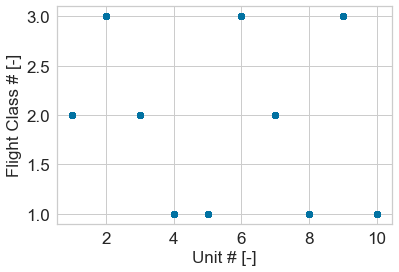

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,3013,567.860041,1359.283102,1706.566019,1126.359986,10.799866,7.907752,10.964331,13.876825,223.949725,...,22984.0,0.652869,79.452560,473.933456,1.0,-0.964095,-2.897319,1,1,2
1,3014,567.585882,1357.937968,1703.216912,1124.405608,10.788754,7.907769,10.953050,13.855286,223.166222,...,22984.0,0.652869,79.100998,473.933744,1.0,-1.014151,-2.796335,1,1,2
2,3017,566.637824,1353.714643,1695.546160,1120.678822,10.752866,7.912485,10.916615,13.781670,220.809029,...,22985.0,0.653625,77.958427,474.016431,1.0,-1.145399,-2.508565,1,1,2
3,3020,566.013942,1351.183604,1690.745730,1118.349690,10.728988,7.913807,10.892374,13.733419,219.395264,...,22987.0,0.653940,77.255310,474.042937,1.0,-1.226378,-2.332506,1,1,2
4,3021,565.756395,1350.421189,1690.046640,1118.230185,10.717152,7.910579,10.880357,13.713054,218.979795,...,22987.0,0.653436,77.079529,473.987688,1.0,-1.247934,-2.288744,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892231,7217758,578.124715,1349.021582,1694.764244,1161.650520,13.418996,10.390338,13.623346,16.690717,248.965434,...,14740.0,0.565425,61.786671,495.908312,87.0,2.060266,-1.222993,0,0,1
892232,7217759,578.136214,1349.041398,1694.838493,1161.705691,13.419978,10.391273,13.624343,16.691884,248.979196,...,14740.0,0.565551,61.786671,495.921066,87.0,2.061792,-1.224536,0,0,1
892233,7217762,578.133894,1349.040609,1694.828318,1161.700971,13.419973,10.391214,13.624338,16.691877,248.982266,...,14739.0,0.565488,61.786671,495.918350,87.0,2.061877,-1.224309,0,0,1
892234,7217764,578.125804,1349.025241,1694.775982,1161.665181,13.419450,10.390678,13.623807,16.691261,248.974554,...,14738.0,0.565362,61.786671,495.909183,87.0,2.061023,-1.223092,0,0,1


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       1     173911
1       3     151391
2       2     111094
totale cluster 0 : 436396
cluster 1
   Classe  Conteggio
0       3     338271
1       2     116084
2       1       1485
totale cluster 1 : 455840
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [20]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 8744.0
max: 17761.0
